# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np

import sys
from collections import deque
from datetime import datetime
import functools
import pickle

import torch

from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
print = functools.partial(print, flush=True)

# override stdout so that we can monitor training after the browser is closed
orig_stdout = sys.stdout
sys.stdout = open('out.txt', 'w')


def save(agent):
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')


def log_and_save(agent, i_episode, scores, save_freq):
    save_epoch = i_episode % save_freq == 0
    print('\r{} Episode {:d}\tAvg: {:.2f}\tCur: {:.2f}'.format(
            datetime.now().strftime('%H:%M:%S'), 
            i_episode, 
            np.mean(scores[-100:]),
            scores[-1]), 
        end='\n' if save_epoch else ''
    )
    with open('scores.pkl', 'wb') as f:
        pickle.dump(scores, f)

    if save_epoch:
        save(agent)


def ddpg(n_episodes, max_t, save_freq):
    scores = []
    try:
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]        # reset the environment
            states = env_info.vector_observations                    # get the initial state
            agent.reset()                                            # reset the agent
            score = np.zeros(20)

            for t in range(max_t):
                actions = agent.act(states)                           # action is clipped to [-1,1] within the agent

                env_info = env.step(actions)[brain_name]             # send all actions to tne environment
                next_states = env_info.vector_observations           # get next state
                rewards = env_info.rewards                           # get reward
                dones = env_info.local_done                          # see if episode finished

                agent.step(states, actions, rewards, next_states, dones)

                states = next_states                                 # roll over states to next time step
                score += rewards                                     # update the score

                if np.any(dones):                                    # episode end
                    break

            scores.append(np.mean(score))
            log_and_save(agent, i_episode, scores, save_freq)

            if np.mean(scores[-100:]) >= 30.0:
                print('\nEnvironment solved. episode={}'.format(i_episode))
                save(agent)
                break
    except KeyboardInterrupt:
        print('\ntraining interrupted. returning current scores')
    return scores

agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

# res_scores = ddpg(n_episodes=10, max_t=1000, save_freq=20)
res_scores = ddpg(n_episodes=1000, max_t=1000, save_freq=20)

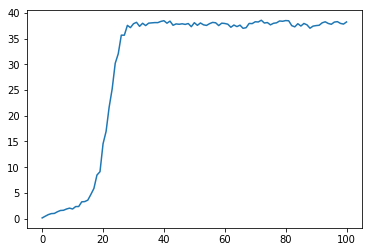

In [6]:
plt.plot(res_scores)

## 5. Load trained agent and verify

In [7]:
trained_agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

trained_agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
trained_agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [9]:
def eval_ddpg(n_episodes, max_t, save_freq):
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]        # reset the environment
        trained_agent.reset()                                    # reset the agent
        states = env_info.vector_observations                    # get the initial state
        score = np.zeros(20)
        
        for t in range(max_t):
            actions = trained_agent.act(states)                   # action is clipped to [-1,1] within the agent
            
            env_info = env.step(actions)[brain_name]              # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state
            rewards = env_info.rewards                         # get reward
            dones = env_info.local_done                        # see if episode finished

            states = next_states                                   # roll over states to next time step
            score += rewards                                      # update the score
            
            if np.any(dones):                                             # episode end
                break
                
        scores.append(np.mean(score))
        print(f'{np.mean(score):.2f}, {np.mean(scores):.2f}')
        
    return scores
        
        

trained_scores = eval_ddpg(n_episodes=10, max_t=1000, save_freq=0)

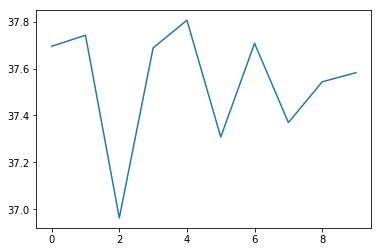

In [10]:
plt.plot(trained_scores)